In [125]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from powerlaw import ccdf

palette = {    
    'azul-claro': '#3a9ee8', 
    'verde': '#5a8417', 
    'bege': '#eae5dc',
    'azul-escuro':'#070052', 
    'cinza': '#4d4d4d'    
}

dataset_dir = './../datasets/'
fig_dir = './plots/dataset_characterization/'
datasets = ['ml-1m', 'book-crossing', 'epinions', 'lastfm']

In [108]:
# datasets_dict = dict()
# for dataset in datasets:
#     print ('Loading', dataset)
#     datasets_dict[dataset] = pd.read_csv(os.path.join(dataset_dir, dataset, dataset+'.inter'), sep='\t', usecols=['uss:float', 'iss:float'])
#     datasets_dict[dataset].columns = [x.split(':')[0] for x in datasets_dict[dataset].columns]
columns = ['dataset', 'uss:float', 'iss:float', 'user_id:token', 'item_id:token']
df = pd.DataFrame(columns=columns)
for dataset in datasets:
    print ('Loading', dataset)
    df_temp = pd.read_csv(os.path.join(dataset_dir, dataset, dataset+'.inter'), sep='\t', usecols=['uss:float', 'iss:float', 'user_id:token', 'item_id:token'])
    df_temp['dataset'] = dataset
    df = df.append(df_temp)
    
df.columns = [x.split(':')[0] for x in df.columns]
df.groupby('dataset').count()

Loading ml-1m
Loading book-crossing
Loading epinions
Loading lastfm


,uss,iss,user_id,item_id
dataset,,,,
book-crossing,1149780,1149780,1149780,1149780
epinions,188477,188478,188477,188478
lastfm,92834,92834,92834,92834
ml-1m,1000209,1000209,1000209,1000209


## Specific Sparsity

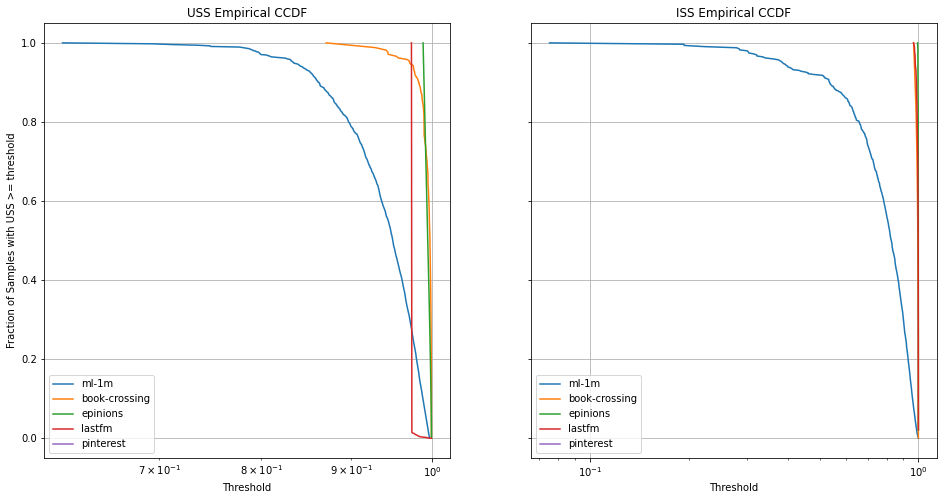

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharey=True)

for dataset in datasets_dict.keys():
    df_inter = df.query('dataset == @dataset')
    for i, column in enumerate(['uss', 'iss']):
        ax = axes[i]
        x, y = ccdf(df_inter[column])

        ax.set_title(column.upper() + " Empirical CCDF")
        ax.plot(x, y, label=dataset)
        ax.set_xscale("log") 
        # ax.set_yscale("log")
        # ax.set_xlim([1])
        ax.set_xlabel("Threshold")
        if i == 0: 
            ax.set_ylabel(f"Fraction of Samples with {column.upper()} >= threshold")
        ax.grid(True)
        ax.legend()


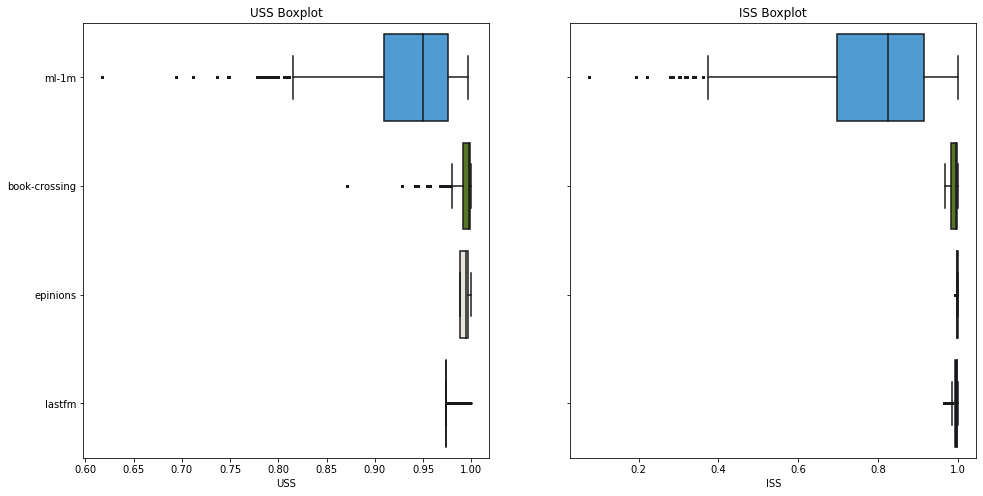

In [95]:
fig, axes = plt.subplots(ncols=2, figsize=(16,8), sharey=True)
analysis = ['uss', 'iss']

for i, ax in enumerate(axes):
    x = analysis[i]
    sns.boxplot(x=x, y='dataset', data=df, ax=ax, palette=palette.values(), fliersize=1)
    # ax.grid(True)    
    ax.set_ylabel('')
    ax.set_xlabel(x.upper())
    ax.set_title(x.upper() + ' Boxplot')

fig.savefig(os.path.join(fig_dir, 'boxplot.png'), bbox_inches='tight')

## Overall Sparsity

In [116]:
def get_overall_sparsity_by_quantile(df, i_quantile, u_quantile):

    iss_threshold = np.quantile(a=df['iss'], q=i_quantile)
    uss_threshold = np.quantile(a=df['uss'], q=u_quantile)
    df = df.query('uss <= @uss_threshold and iss <= @iss_threshold')
    inter_num = df.shape[0]
    n_users = df['user_id'].nunique()+1
    n_items = df['item_id'].nunique()+1

    return 1-inter_num/(n_users*n_items)

In [165]:
quantiles = [0.25, 0.5, 0.75, 1]
dataset = datasets[3]

arr_os = np.zeros((len(quantiles), len(quantiles)))
for u, u_quantile in enumerate(quantiles[::-1]):
    for i, i_quantile in enumerate(quantiles):
        arr_os[u][i] = get_overall_sparsity_by_quantile(df.query('dataset == @dataset'), i_quantile, u_quantile)

arr_os

array([[0.88494102, 0.99731602, 0.99728857, 0.99721881],
       [0.88375564, 0.99720665, 0.99718878, 0.99712387],
       [0.88375564, 0.99720665, 0.99718878, 0.99712387],
       [0.88375564, 0.99720665, 0.99718878, 0.99712387]])

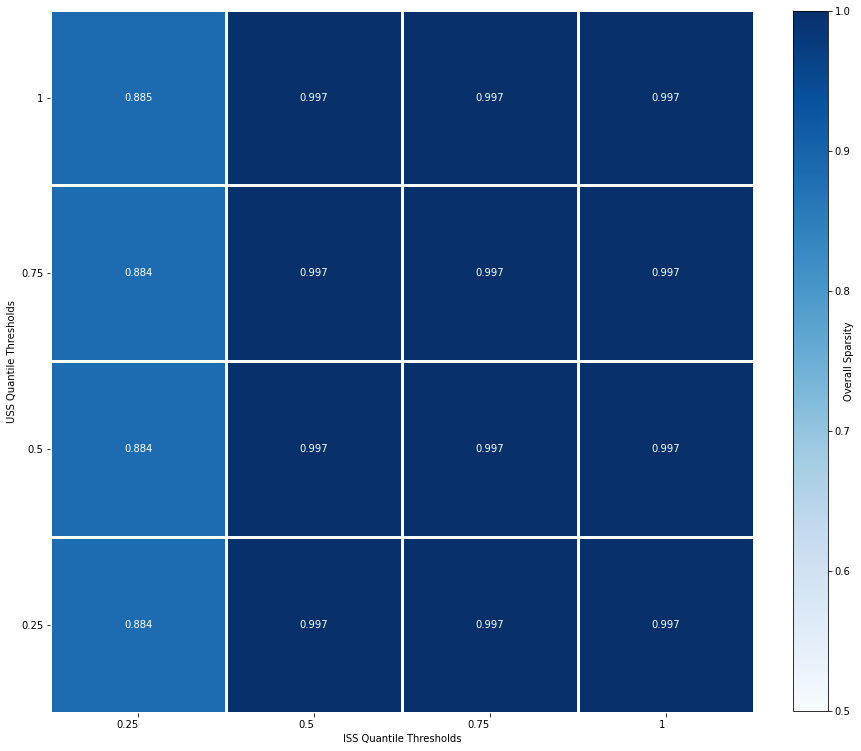

In [168]:
#https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):    
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, vmin=0.5, vmax=1.0, **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.05, shrink=0.92, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")    

    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))    
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

fig, ax = plt.subplots(figsize=(14,14))
im, cbar = heatmap(arr_os, quantiles[::-1], quantiles, ax, cmap="Blues", cbarlabel='Overall Sparsity')
texts = annotate_heatmap(im, valfmt="{x:.3f}")
ax.set_xlabel('ISS Quantile Thresholds')
ax.set_ylabel('USS Quantile Thresholds')

fig.savefig(os.path.join(fig_dir, f'{dataset}_os.png'), bbox_inches='tight')